# MLP example

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import random

import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    for kgpu in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[kgpu], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

2023-05-11 11:56:32.601764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]


2023-05-11 11:56:42.919495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-11 11:56:42.919558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cori16): /proc/driver/nvidia/version does not exist


## Build data pipeline

### input and output variable list
- Note that ptend_t and ptend_q0001 are not in the output (mlo) netcdf files, but calculated real-time on a tf Dataset object.
- Variable list: https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0

In [3]:
# in/out variable lists
vars_mli = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

## tf Dataset pipeline
- ref: https://www.noahbrenowitz.com/post/loading_netcdfs/
- ref: https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [5]:
mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
mli_min = xr.open_dataset('./norm_factors/mli_min.nc')
mli_max = xr.open_dataset('./norm_factors/mli_max.nc')
mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')

def load_nc_dir_with_generator(filelist:list):
    def gen():
        for file in filelist:
            
            # read mli
            ds = xr.open_dataset(file, engine='netcdf4')
            ds = ds[vars_mli]
            
            # read mlo
            dso = xr.open_dataset(file.replace('.mli.','.mlo.'), engine='netcdf4')
            
            # make mlo variales: ptend_t and ptend_q0001
            dso['ptend_t'] = (dso['state_t'] - ds['state_t'])/1200 # T tendency [K/s]
            dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001'])/1200 # Q tendency [kg/kg/s]
            dso = dso[vars_mlo]
            
            # normalizatoin, scaling
            ds = (ds-mli_mean)/(mli_max-mli_min)
            dso = dso*mlo_scale

            # stack
            #ds = ds.stack({'batch':{'sample','ncol'}})
            ds = ds.stack({'batch':{'ncol'}})
            ds = ds.to_stacked_array("mlvar", sample_dims=["batch"], name='mli')
            #dso = dso.stack({'batch':{'sample','ncol'}})
            dso = dso.stack({'batch':{'ncol'}})
            dso = dso.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')
            
            yield (ds.values, dso.values)

    return tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float64, tf.float64),
        output_shapes=((None,124),(None,128))
    )

## Instantiate tf.data.Dataset object here
- Dataset file size and dimensions: https://docs.google.com/document/d/1HgfZZJM0SygjWvSAJ5kSfql9aXUFkvLybL36p-vmdZc/edit

In [13]:
shuffle_buffer=384*12

# for training

# # First 5 days of each month for the first 6 years
# f_mli1 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.000[123456]-*-0[12345]-*.nc')
# f_mli2 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-01-0[12345]-*.nc')
# f_mli = [*f_mli1, *f_mli2]

# every 10th sample
f_mli1 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.000[123456]-*-*-*.nc')
f_mli2 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-01-*-*.nc')
f_mli = sorted([*f_mli1, *f_mli2])
random.shuffle(f_mli)
f_mli = f_mli[::10]

# # debugging
# f_mli = f_mli[0:72*5]

random.shuffle(f_mli)
print(f'[TRAIN] Total # of input files: {len(f_mli)}')
print(f'[TRAIN] Total # of columns (nfiles * ncols): {len(f_mli)*384}')
tds = load_nc_dir_with_generator(f_mli)
tds = tds.unbatch()
tds = tds.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
tds = tds.prefetch(buffer_size=4) # in realtion to the batch size

# for validation

# # First 5 days of each month for the following 2 years
# f_mli1 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-0[23456789]-0[12345]-*.nc')
# f_mli2 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-1[012]-0[12345]-*.nc')
# f_mli3 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.000[89]-*-0[12345]-*.nc')
# f_mli_val = [*f_mli1, *f_mli2, *f_mli3]

# every 10th sample
f_mli1 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-0[23456789]-0[12345]-*.nc')
f_mli2 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-1[012]-0[12345]-*.nc')
f_mli3 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.000[89]-*-0[12345]-*.nc')
f_mli_val = sorted([*f_mli1, *f_mli2, *f_mli3])
f_mli_val = f_mli_val[::10]

# # debugging
# f_mli_val = f_mli_val[0:72*5]

random.shuffle(f_mli_val)
print(f'[VAL] Total # of input files: {len(f_mli_val)}')
print(f'[VAL] Total # of columns (nfiles * ncols): {len(f_mli_val)*384}')
tds_val = load_nc_dir_with_generator(f_mli_val)
tds_val = tds_val.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
tds_val = tds_val.prefetch(buffer_size=4) # in realtion to the batch size

#list(tds)
# for count_batch in tds.repeat().batch(10).take(1):
#     print(count_batch[0].numpy())
#count_batch[0].shape

[TRAIN] Total # of input files: 15768
[TRAIN] Total # of columns (nfiles * ncols): 6054912


2023-05-10 19:35:17.017261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 19:35:18.753492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38250 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-05-10 19:35:18.755102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38250 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-05-10 19:35:18.756681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/rep

[VAL] Total # of input files: 864
[VAL] Total # of columns (nfiles * ncols): 331776


## ML training
- While 4 GPUs are available on the node, using multi GPUs (with 'tf.distribute.MirroredStrategy()' strategy) does not speed up training process. It is possibly due to that the current Dataset pipeline is sequential.

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [14]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

# model params
input_length = 2*60 + 4
output_length_lin  = 2*60
output_length_relu = 8
output_length = output_length_lin + output_length_relu
n_nodes = 512

# constrcut a model
input_layer    = keras.layers.Input(shape=(input_length,), name='input')
hidden_0       = keras.layers.Dense(n_nodes, activation='relu')(input_layer)
hidden_1       = keras.layers.Dense(n_nodes, activation='relu')(hidden_0)
output_pre     = keras.layers.Dense(output_length, activation='elu')(hidden_1)
output_lin     = keras.layers.Dense(output_length_lin,activation='linear')(output_pre)
output_relu    = keras.layers.Dense(output_length_relu,activation='relu')(output_pre)
output_layer   = keras.layers.Concatenate()([output_lin, output_relu])

model = keras.Model(input_layer, output_layer, name='Emulator')
model.summary()

# compile
model.compile(optimizer=keras.optimizers.Adam(), #optimizer=keras.optimizers.Adam(learning_rate=clr),
              loss='mse',
              metrics=['mse','mae','accuracy'])

Model: "Emulator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 124)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          64000       ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 512)          262656      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          65664       ['dense_1[0][0]']                
                                                                                           

In [15]:
# callbacks
# a. tensorboard
tboard_callback = keras.callbacks.TensorBoard(log_dir = './logs_tensorboard',
                                              histogram_freq = 1,)

# b. checkpoint
filepath_checkpoint = 'saved_model/best_model_proto.h5'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=filepath_checkpoint,
                                                            save_weights_only=False,
                                                            monitor='val_mse',
                                                            mode='min',
                                                            save_best_only=True)

# c. csv logger
filepath_csv = 'csv_logger.txt'
csv_callback = keras.callbacks.CSVLogger(filepath_csv, separator=",", append=True)

my_callbacks= [tboard_callback, checkpoint_callback, csv_callback]

# !mkdir logs_tensorboard
# !mkdir saved_model

In [ ]:
# Manually shuffling the order of input files.
# "tds = tds.shuffle(buffer_size=<global>, reshuffle_each_iteration=True)" is possible,
# however, it is slow.
# So employing global shuffle (by file names) + local shuffle (using .shuffle).

N_EPOCHS = 30
shuffle_buffer = 12*384 #ncol=384
batch_size= 96 # 384/4

n=0
while n < N_EPOCHS:
    random.shuffle(f_mli)
    tds = load_nc_dir_with_generator(f_mli) # global shuffle by file names
    tds = tds.unbatch()
 # local shuffle by elements    tds = tds.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=False)
    tds = tds.batch(batch_size)
    tds = tds.prefetch(buffer_size=int(shuffle_buffer/384)) # in realtion to the batch size

    random.shuffle(f_mli_val)
    tds_val = load_nc_dir_with_generator(f_mli_val)
    tds_val = tds_val.unbatch()
    tds_val = tds_val.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=False)
    tds_val = tds_val.batch(batch_size)
    tds_val = tds_val.prefetch(buffer_size=int(shuffle_buffer/384))
    
    print(f'Epoch: {n+1}')
    model.fit(tds, 
              validation_data=tds_val,
              callbacks=my_callbacks)
    
    n+=1

Epoch: 1


2023-05-10 19:37:27.583558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-10 19:37:27.595604: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9918018250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 19:37:27.595620: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-05-10 19:37:27.595624: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-05-10 19:37:27.595626: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-05-10 19:37:27.595629: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-05-10 1

63072/63072 [==============================] - 1096s 17ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0254 - accuracy: 0.9727 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0244 - val_accuracy: 0.9762
Epoch: 2
63072/63072 [==============================] - 1071s 17ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0240 - accuracy: 0.9761 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0238 - val_accuracy: 0.9766
Epoch: 3
63072/63072 [==============================] - 1035s 16ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0238 - accuracy: 0.9769 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0237 - val_accuracy: 0.9774
Epoch: 4
63072/63072 [==============================] - 1035s 16ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0236 - accuracy: 0.9773 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0239 - val_accuracy: 0.9764
Epoch: 5
63072/63072 [==============================] - 1033s 16ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0236 - accuracy: 0.9775 - val_loss: 0.0039 - val_ms

## Data Pipeline Sanity Check

In [145]:
# new dataset generator function
# that has new options (latlim, lonlim)

mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
mli_min = xr.open_dataset('./norm_factors/mli_min.nc')
mli_max = xr.open_dataset('./norm_factors/mli_max.nc')
mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')
ne4_grid_info = xr.open_dataset('./test_data/E3SM-MMF_ne4_grid-info.orig.nc')

def load_nc_dir_with_generator_test(filelist:list, latlim=[-999,999], lonlim=[-999,999]):
    def gen():
        for file in filelist:
            
            # read mli
            ds = xr.open_dataset(file, engine='netcdf4')
            ds = ds[vars_mli]
            ds = ds.merge(ne4_grid_info[['lat','lon']])
            ds = ds.where((ds['lat']>latlim[0])*(ds['lat']<latlim[1]),drop=True)
            ds = ds.where((ds['lon']>lonlim[0])*(ds['lon']<lonlim[1]),drop=True)
            
            # read mlo
            dso = xr.open_dataset(file.replace('.mli.','.mlo.'), engine='netcdf4')
            dso = dso.merge(ne4_grid_info[['lat','lon']])
            dso = dso.where((dso['lat']>latlim[0])*(dso['lat']<latlim[1]),drop=True)
            dso = dso.where((dso['lon']>lonlim[0])*(dso['lon']<lonlim[1]),drop=True)
            
            # make mlo variales: ptend_t and ptend_q0001
            dso['ptend_t'] = (dso['state_t'] - ds['state_t'])/1200 # T tendency [K/s]
            dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001'])/1200 # Q tendency [kg/kg/s]
            dso = dso[vars_mlo]
            
            # normalizatoin, scaling
            ds = (ds-mli_mean)/(mli_max-mli_min)
            dso = dso*mlo_scale

            # stack
            #ds = ds.stack({'batch':{'sample','ncol'}})
            ds = ds.stack({'batch':{'ncol'}})
            ds = ds.to_stacked_array("mlvar", sample_dims=["batch"], name='mli')
            #dso = dso.stack({'batch':{'sample','ncol'}})
            dso = dso.stack({'batch':{'ncol'}})
            dso = dso.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')
            
            yield (ds.values, dso.values)

    return tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float64, tf.float64),
        output_shapes=((None,124),(None,128))
    )

One day snapshot

In [287]:
# every 10th sample
dir_test_samples = '/global/homes/s/sungduk/work/LEAP/E3SM-MMF_baseline/test_data/0010-01'
f_mli = sorted(glob.glob(f'{dir_test_samples}/E3SM-MMF.mli.0010-01-*.nc'))
f_mli = f_mli[:1]
print(f'#files: {len(f_mli)}')
tds_test = load_nc_dir_with_generator_test(f_mli)

#files: 1


In [346]:
# creating numpy array defeats the purpose of tf Dataset pipeline,
# but, just doing it here for quick sanity check.
work = list(tds_test.as_numpy_iterator())
x_true = np.concatenate([ work[k][0] for k in range(len(work)) ])
y_true = np.concatenate([ work[k][1] for k in range(len(work)) ])

In [290]:
model = keras.models.load_model("./saved_model/best_model_proto.h5")
y_pred = model(x_true)

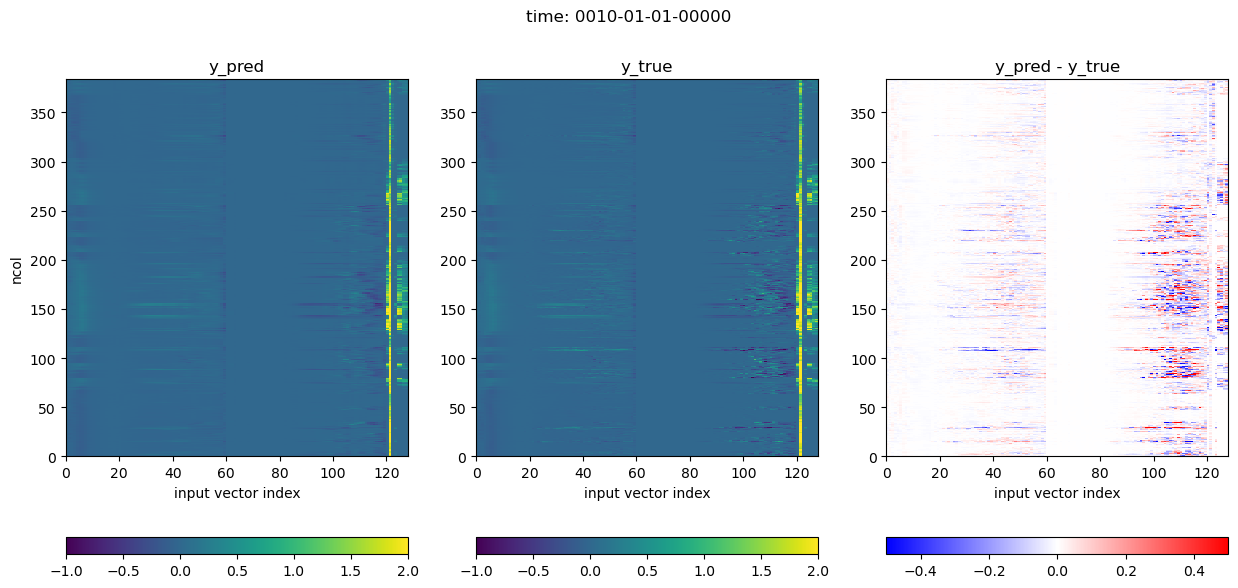

In [301]:
fig, ax_ = plt.subplots(ncols=3)
fig.suptitle(f'time: {f_mli[0].split(".")[-2]}')
ax = ax_[0]
h0 = ax.pcolor(y_pred, vmin=-1, vmax=2)
ax.set_title('y_pred')
ax.set_ylabel('ncol')
ax.set_xlabel('input vector index')
plt.colorbar(h0, orientation='horizontal')
ax = ax_[1]
h1 = ax.pcolor(y_true, vmin=-1, vmax=2)
ax.set_title('y_true')
ax.set_xlabel('input vector index')
plt.colorbar(h1, orientation='horizontal')
ax = ax_[2]
h2 = ax.pcolor(y_pred-y_true, vmin=-.5,vmax=.5,cmap='bwr')
ax.set_title('y_pred - y_true')
ax.set_xlabel('input vector index')
plt.colorbar(h2, orientation='horizontal')

fig.set_size_inches(15,7)

5 day mean and time series

In [303]:
dir_test_samples = '/global/homes/s/sungduk/work/LEAP/E3SM-MMF_baseline/test_data/0010-01'
f_mli = sorted(glob.glob(f'{dir_test_samples}/E3SM-MMF.mli.0010-01-0[12345]-*.nc'))
print(f'#files: {len(f_mli)}')
tds_test = load_nc_dir_with_generator_test(f_mli, latlim=[-10,10], lonlim=[160,200])

#files: 360


In [304]:
# creating numpy array defeats the purpose of tf Dataset pipeline,
# but, just doing it here for quick sanity check.

work = list(tds_test.as_numpy_iterator())
x_true = np.concatenate([ work[k][0] for k in range(len(work)) ])
y_true = np.concatenate([ work[k][1] for k in range(len(work)) ])
print(x_true.shape, y_true.shape)

model = keras.models.load_model("./saved_model/best_model_proto.h5")
y_pred = model(x_true)

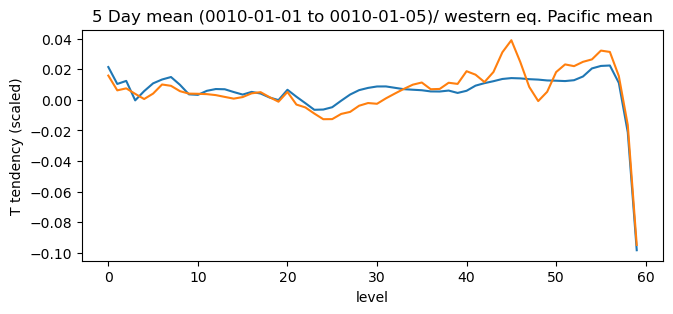

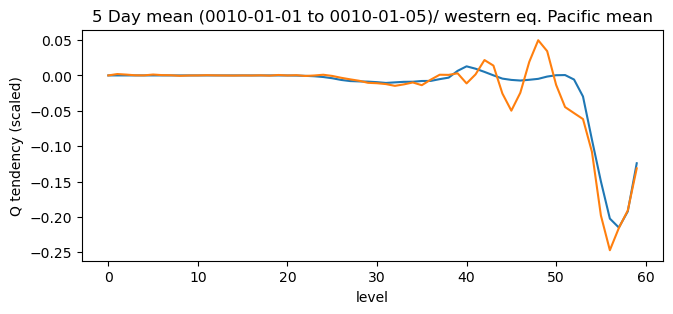

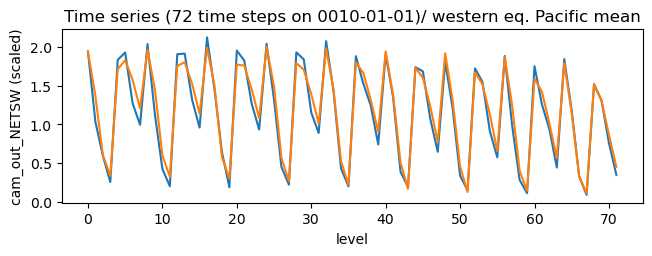

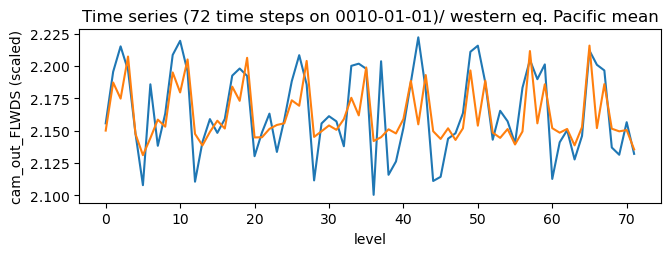

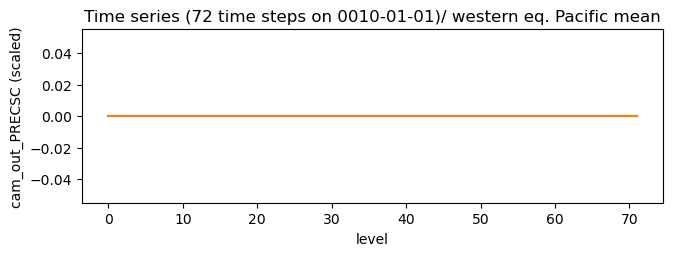

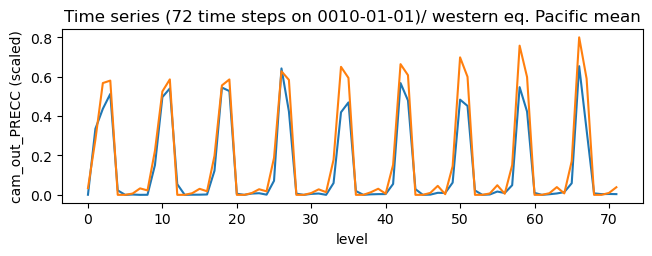

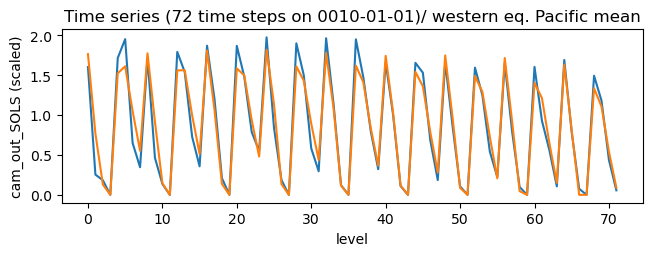

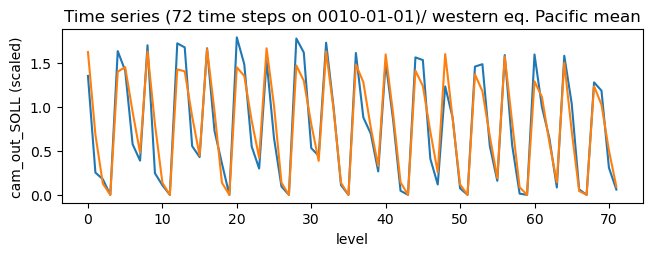

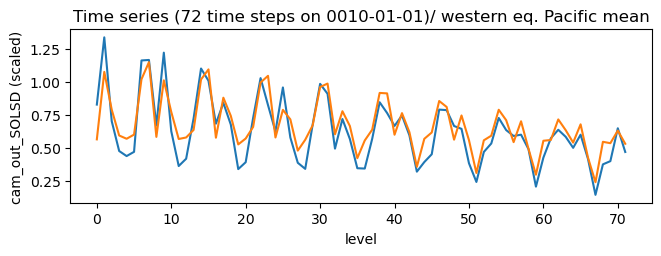

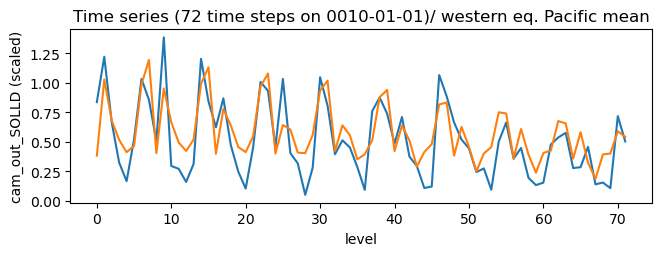

In [345]:
fig, ax = plt.subplots()
y_true_mean_T = np.mean(y_true[:,:60], axis=0)
y_pred_mean_T = np.mean(y_pred[:,:60], axis=0)
ax.plot(y_true_mean_T)
ax.plot(y_pred_mean_T)
ax.set_title('5 Day mean (0010-01-01 to 0010-01-05)/ western eq. Pacific mean')
ax.set_xlabel('level')
ax.set_ylabel('T tendency (scaled)')
fig.set_size_inches(7.5,3)

fig, ax = plt.subplots()
y_true_mean_Q = np.mean(y_true[:,60:120], axis=0)
y_pred_mean_Q = np.mean(y_pred[:,60:120], axis=0)
ax.plot(y_true_mean_Q)
ax.plot(y_pred_mean_Q)
ax.set_title('5 Day mean (0010-01-01 to 0010-01-05)/ western eq. Pacific mean')
ax.set_xlabel('level')
ax.set_ylabel('Q tendency (scaled)')
fig.set_size_inches(7.5,3)

for k, kvar in enumerate(vars_mlo[2:]):
    fig, ax = plt.subplots()
    
    y_true_surface_var = y_true[:,120+k][:72*1]
    y_pred_surface_var = y_pred[:,120+k][:72*1]
    
    ax.plot(y_true_surface_var)
    ax.plot(y_pred_surface_var)
    
    ax.set_title('Time series (72 time steps on 0010-01-01)/ western eq. Pacific mean')
    ax.set_xlabel('level')
    ax.set_ylabel(f'{kvar} (scaled)')
    fig.set_size_inches(7.5,2.25)